In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
from pathlib import Path
DATA_DIR = Path("../../data/clean_data_splits")

In [5]:
X_train = pd.read_csv(DATA_DIR /"X_train.csv")
X_val   = pd.read_csv(DATA_DIR /"X_val.csv")
X_test  = pd.read_csv(DATA_DIR /"X_test.csv")

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape:   {X_val.shape}")
print(f"X_test shape:  {X_test.shape}")

X_train shape: (1611, 31)
X_val shape:   (20, 31)
X_test shape:  (21, 31)


In [6]:
# Scale Features
# PCA is sensitive to feature scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

In [7]:
# Fit PCA
# Keep all components for explained variance analysis
pca = PCA(n_components=X_train.shape[1])
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca   = pca.transform(X_val_scaled)
X_test_pca  = pca.transform(X_test_scaled)


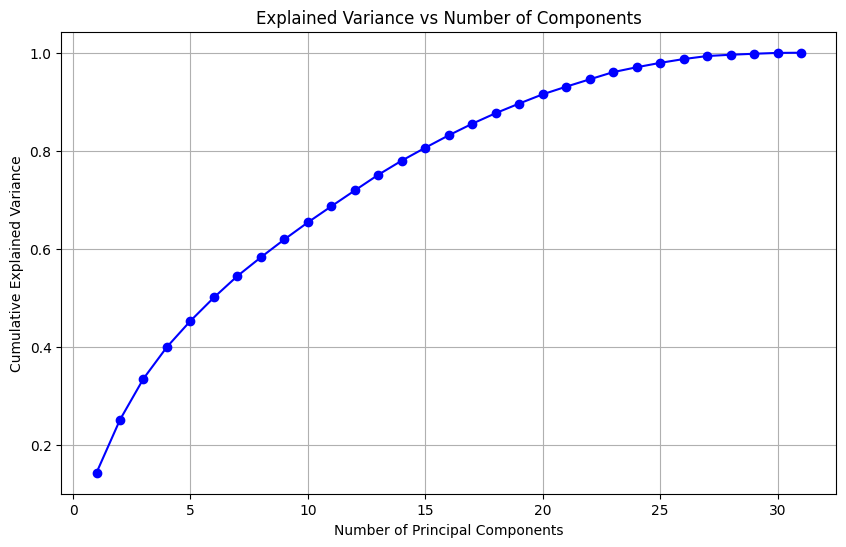

In [9]:
# Explained variance

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10,6))
plt.plot(range(1, len(explained_variance)+1), cumulative_variance, marker='o', color='blue')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs Number of Components")
plt.grid(True)
plt.show()

In [13]:
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components to retain 95% variance: {n_components_90}")

Number of components to retain 95% variance: 20


In [14]:
# Project Data to Top Components
# Reduce to n_components_95

pca_reduced = PCA(n_components=n_components_90)
X_train_pca_reduced = pca_reduced.fit_transform(X_train_scaled)
X_val_pca_reduced   = pca_reduced.transform(X_val_scaled)
X_test_pca_reduced  = pca_reduced.transform(X_test_scaled)

print(f"X_train reduced shape: {X_train_pca_reduced.shape}")
print(f"X_val reduced shape:   {X_val_pca_reduced.shape}")
print(f"X_test reduced shape:  {X_test_pca_reduced.shape}")

X_train reduced shape: (1611, 20)
X_val reduced shape:   (20, 20)
X_test reduced shape:  (21, 20)


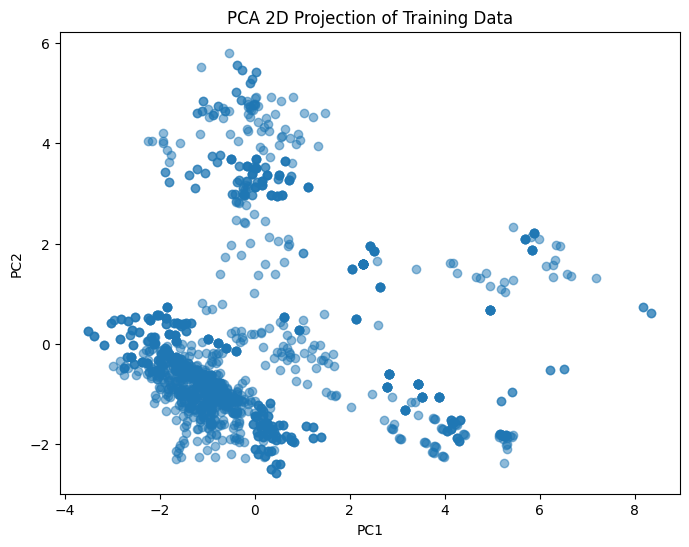

In [15]:
# 2D PCA Visualization
# -------------------------------
plt.figure(figsize=(8,6))
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA 2D Projection of Training Data")
plt.show()

In [16]:
pd.DataFrame(X_train_pca_reduced).to_csv(DATA_DIR/"X_train_pca.csv", index=False)
pd.DataFrame(X_val_pca_reduced).to_csv(DATA_DIR/"X_val_pca.csv", index=False)
pd.DataFrame(X_test_pca_reduced).to_csv(DATA_DIR/"X_test_pca.csv", index=False)

print("PCA-transformed datasets saved successfully.")


PCA-transformed datasets saved successfully.
